In [1]:
import sys
import os
import pandas as pd
import numpy as np
import pymc

sys.path.append(f'{os.path.dirname(os.path.dirname(os.getcwd()))}/draft_pick_prob')

In [2]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv')
draft_df = pd.read_csv('2020_draft_order.csv')

'''
mock_draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_BM_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_BM'})
mock_draft_df_2=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CB_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CB'})
mock_draft_df_3=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CC_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CHRIS'})
mock_draft_df_4=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CP_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP'})
mock_draft_df_5=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_SK_mockdraft.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_SK'})
mock_draft_df_6=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_CP_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_CP_bb'})
mock_draft_df_7=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_DN_bb.csv').sort_values(by='RANK').rename(columns={'RANK':'RANK_DN_bb'})
'''
possible_players=pd.read_csv('2020_PLAYER_IDS.csv')

In [4]:
#draft_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2021_validation/2021_draft_order.csv',encoding='ISO-8859-1')

file_list =['2020_BM_mockdraft.csv','2020_CB_mockdraft.csv','2020_CC_mockdraft.csv','2020_CP_mockdraft.csv','2020_SK_mockdraft.csv','2020_CP_bb.csv','2020_DN_bb.csv']

mock_draft_dfs = []


for filename in file_list:
    df = pd.read_csv(filename)  # Read the CSV file
    
    # Sort the DataFrame by 'RANK' column
    df = df.sort_values(by='RANK')
    
    
    prefix = filename[5:7]
        
    # Rename the 'RANK' column based on the extracted prefix
    if filename[-6:-4]== 'bb':
        df = df.rename(columns={'RANK': f'bb_RANK_{prefix}'})
    else:
        df = df.rename(columns={'RANK': f'md_RANK_{prefix}'})
    
    mock_draft_dfs.append(df)  # Add the processed DataFrame to the list




In [5]:
import math
df_player_rankings=possible_players[['PLAYER_ID']].merge(mock_draft_dfs[0][['PLAYER_ID','md_RANK_BM']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[1][['PLAYER_ID','md_RANK_CB']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[2][['PLAYER_ID','md_RANK_CC']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[3][['PLAYER_ID','md_RANK_CP']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[4][['PLAYER_ID','md_RANK_SK']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[5][['PLAYER_ID','bb_RANK_CP']], how='left', on=['PLAYER_ID'])
df_player_rankings=df_player_rankings.merge(mock_draft_dfs[6][['PLAYER_ID','bb_RANK_DN']], how='left', on=['PLAYER_ID'])


df_player_rankings

,PLAYER_ID,md_RANK_BM,md_RANK_CB,md_RANK_CC,md_RANK_CP,md_RANK_SK,bb_RANK_CP,bb_RANK_DN
0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2,3.0,2.0,2.0,3.0,2.0,2.0,2.0
2,3,2.0,3.0,3.0,2.0,3.0,3.0,3.0
3,4,6.0,5.0,7.0,7.0,8.0,4.0,6.0
4,5,8.0,6.0,5.0,5.0,5.0,13.0,10.0
...,...,...,...,...,...,...,...,...
226,228,NaN,NaN,NaN,NaN,NaN,110.0,NaN
227,229,NaN,NaN,NaN,NaN,NaN,115.0,NaN
228,230,NaN,NaN,NaN,NaN,NaN,119.0,NaN
229,231,NaN,NaN,NaN,NaN,NaN,120.0,NaN


In [8]:
def likelihood(strengths, rankings):
    # params: vector of parameters [intercept, slope]
    likelihood=1
    counter=1
    paired_lists = list(zip(strengths, rankings))
    sorted_pairs = sorted(paired_lists, key=lambda x: x[1])
    sorted_list1, sorted_list2 = zip(*sorted_pairs)
    while counter<len(sorted_list2)+1 and sorted_list2[counter]!=sorted_list2[counter+1]:

        likelihood+=np.log(np.exp(sorted_list1[counter-1])/np.sum(np.exp(sorted_list1[counter-1:])))
        counter+=1
    return likelihood

def neg_log_likelihood(params, df):
    neg_ll = 1  # Initialize as 0 for correct accumulation
    columns_to_go_through = df.columns[1:]
    for i in columns_to_go_through:
        max_rank = df[i].max() + 1
        player_rank = list(df[i])
        fixed_player_rank = [max_rank if math.isnan(x) else x for x in player_rank]
        
        # Determine the weighting factor based on column name
        if i.startswith('bb'):
            weight = 0.5  # Example: 0.5 for less value
        elif i.startswith('md'):
            weight = 1.0  # Example: 1.0 (or more) for 'md' columns
        else:
            weight = 1.0  # Default weight for other columns

        # Apply the weighting factor
        neg_ll -= weight * likelihood(params, fixed_player_rank)

    return neg_ll

In [9]:
def constraint_eq(x):
    return sum(x)

In [10]:
import scipy.optimize

counter=40
l_play=[]
variable_bounds=[]
count=0

while count<len(df_player_rankings):
    l_play.append(counter)
    count+=1
    counter-=0.20
    variable_bounds.append((-40,40))

result = scipy.optimize.minimize(neg_log_likelihood, l_play, args=(df_player_rankings,), method='SLSQP', bounds=variable_bounds, constraints={'type': 'eq', 'fun': constraint_eq})
print(result.x)

[ 40.          31.69352129  31.001059    21.27305034  20.63369989
  21.96180096  19.12725872  17.6628036   20.6447585   21.02108057
  18.56512711  18.65968778  17.26207067  16.04161305  14.90716088
  15.07144812  14.54757169  16.94925663  16.01696132  10.79518613
 -38.91602442  14.59503916  12.51050392  15.08705265  13.34924559
  12.22031333  14.6993634   13.37578679  13.86537008  13.59830342
  11.2601734   11.31085758   9.71393088  -3.62357859  11.79988688
  11.21065426  12.19490943  11.44136192  11.7442732    9.08290085
  13.06606797   8.08205025   8.14803509   7.5101138    9.16652297
   7.52914381   9.33406847  11.42505153   9.34152802   8.49104619
   6.02713456   8.07408198   9.08191018   7.44385552   6.00065053
   7.42402887  -4.49474784  10.15037652  10.43533072   7.87280668
  -4.27516029   9.70862103  11.36152002  10.53999355   8.2570601
   7.15102586  10.54695757   5.96799806   7.39241473  -3.70319713
  12.3371967   -3.63907967  11.33184842  10.61947182   9.4692862
  -3.5945601

In [11]:
player_ability_parameters_df=pd.read_csv('/Users/tiffanieli/Documents/EMSF_CAPSTONE/draft_pick_prob/model_validation/2020_validation/2020_PLAYER_IDS.csv')
player_ability_parameters_df['ABILITY_PARAMS']=result.x
player_ability_parameters_df=player_ability_parameters_df.sort_values(by='ABILITY_PARAMS', ascending=False, axis=0)
player_ability_parameters_df['SIM_RANK'] = range(1, len(player_ability_parameters_df) + 1)
player_ability_parameters_df.head(10)

,PLAYER_NAME,PLAYER_ID,ABILITY_PARAMS,SIM_RANK
0,Alexis Lafreniere,1,40.000000,1
1,Quinton Byfield,2,31.693521,2
2,Tim Stutzle,3,31.001059,3
5,Jamie Drysdale,6,21.961801,4
3,Lucas Raymond,4,21.273050,5
9,Cole Perfetti,10,21.021081,6
8,Marco Rossi,9,20.644758,7
4,Jake Sanderson,5,20.633700,8
6,Alexander Holtz,7,19.127259,9
11,Anton Lundell,12,18.659688,10


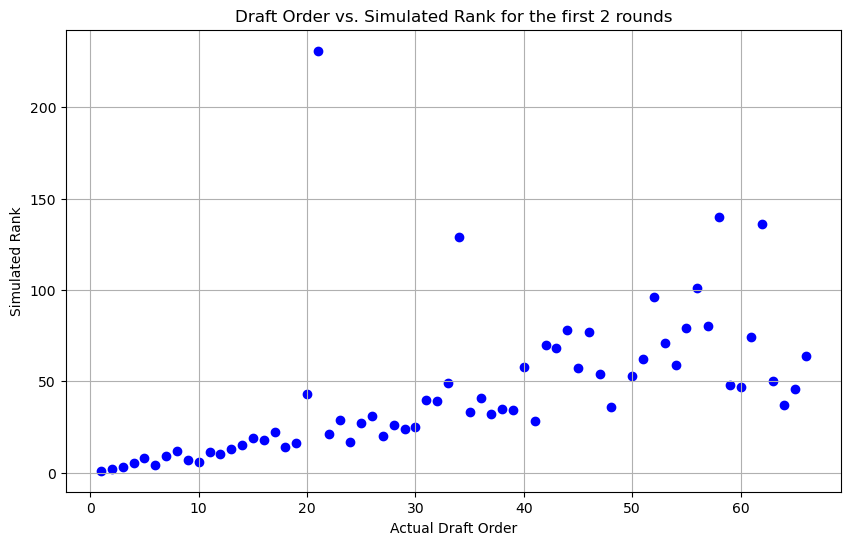

In [12]:
import matplotlib.pyplot as plt

# Assuming you have DataFrames: draft_df and player_ability_parameters_df

# Merge the two DataFrames on the 'PLAYER_NAME' column
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_ID', 'ORDER']], on='PLAYER_ID')
merged_df = merged_df.sort_values(by='ORDER')
merged_df
# Filter the data for the first 100 orders
merged_df_first_100 = merged_df.head(65)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_first_100['ORDER'], merged_df_first_100['SIM_RANK'], c='blue', label='Draft Order vs. Simulated Rank')
plt.xlabel('Actual Draft Order')
plt.ylabel('Simulated Rank')
plt.title('Draft Order vs. Simulated Rank for the first 2 rounds')
plt.grid(True)


plt.show()



In [13]:
#Error -Mean absolute error (MAE)
merged_df = player_ability_parameters_df.merge(draft_df[['PLAYER_NAME', 'ORDER']], on='PLAYER_NAME')
merged_df = merged_df.sort_values(by='ORDER')
merged_df = merged_df.head(32)
merged_df['ERROR'] = abs(merged_df['SIM_RANK']-merged_df['ORDER'])
mae = merged_df['ERROR'].sum()/len(merged_df['ERROR'])
print(mae)

#0.2 gives 9.88
#0.5 give 10.25
# 0.8 gives 10.34
# 1 gives 10.59



10.25
